## Фаза1. Неделя 1. Среда


### A/B - тесты

In [58]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [59]:
transactions = pd.read_csv("data/transactions.csv").drop("Unnamed: 0", axis=1)
users = pd.read_csv("data/users.csv").drop("Unnamed: 0", axis=1)

In [60]:
transactions.head()

,transaction_id,user_id,date,revenue,group
0,6776893763,3392612285,2017-06-15,3758.2,B
1,40289040,8006342366,2017-06-15,1518.7,B
2,1256395556,966904442,2017-06-15,778.4,A
3,4376547739,9761119562,2017-06-15,27081.5,B
4,2237026988,8938272722,2017-06-15,5456.7,B


In [61]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1197 non-null   int64  
 1   user_id         1197 non-null   int64  
 2   date            1197 non-null   object 
 3   revenue         1197 non-null   float64
 4   group           1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [62]:
users.head()

,date,group,count_users
0,2017-06-01,A,1016.0
1,2017-06-02,A,868.0
2,2017-06-03,A,704.0
3,2017-06-04,A,1013.0
4,2017-06-05,A,1072.0


In [63]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1197 non-null   int64  
 1   user_id         1197 non-null   int64  
 2   date            1197 non-null   object 
 3   revenue         1197 non-null   float64
 4   group           1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


1. Постройте график кумулятивной выручки по группам. Опишите выводы

In [64]:
transactions["date"] = pd.to_datetime(transactions["date"])

In [65]:
daily_rev = (
    transactions.groupby(["date", "group"], as_index=False)["revenue"]
    .sum()
    .rename(columns={"revenue": "daily_revenue"})
)

In [66]:
daily_rev["cum_revenue"] = (
    daily_rev.sort_values(["group", "date"]).groupby("group")["daily_revenue"].cumsum()
)

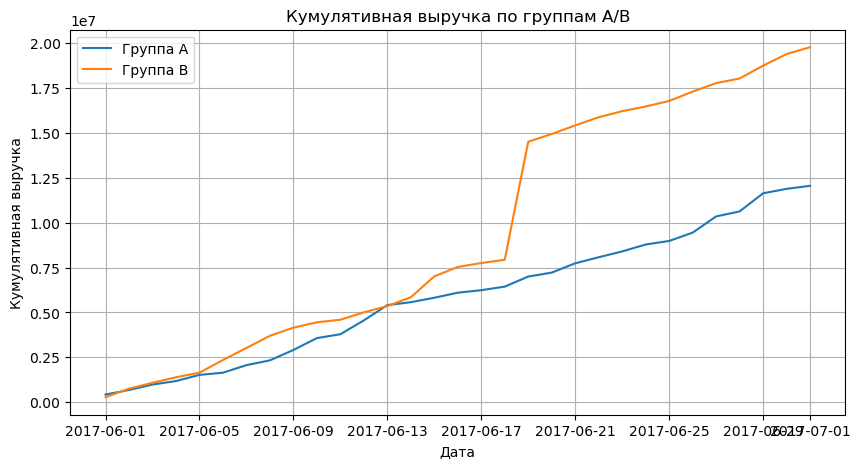

In [67]:
plt.figure(figsize=(10, 5))
for group in daily_rev["group"].unique():
    group_data = daily_rev[daily_rev["group"] == group]
    plt.plot(group_data["date"], group_data["cum_revenue"], label=f"Группа {group}")

plt.title("Кумулятивная выручка по группам A/B")
plt.xlabel("Дата")
plt.ylabel("Кумулятивная выручка")
plt.grid()
plt.legend()
plt.show()

Группа B показывает лучший результат по кумулятивной выручке

2. Постройте график кумулятивного среднего чека по группам. Опишите выводы

In [68]:
daily_rev.head()

,date,group,daily_revenue,cum_revenue
0,2017-06-01,A,420253.3,420253.3
1,2017-06-01,B,271805.0,271805.0
2,2017-06-02,A,255111.9,675365.2
3,2017-06-02,B,477378.1,749183.1
4,2017-06-03,A,302952.4,978317.6


In [69]:
daily_orders = (
    transactions.groupby(["date", "group"]).size().reset_index(name="daily_orders")
)


daily_orders = daily_orders.sort_values(["group", "date"]).assign(
    cum_orders=lambda d: d.groupby("group")["daily_orders"].cumsum()
)


daily = (
    daily_rev[["date", "group", "cum_revenue"]]
    .merge(
        daily_orders[["date", "group", "cum_orders"]], on=["date", "group"], how="inner"
    )
    .sort_values(["group", "date"])
)


daily["cum_avg_check"] = daily["cum_revenue"] / daily["cum_orders"]

In [70]:
daily.head()

,date,group,cum_revenue,cum_orders,cum_avg_check
0,2017-06-01,A,420253.3,24,17510.554167
2,2017-06-02,A,675365.2,44,15349.209091
4,2017-06-03,A,978317.6,68,14387.023529
6,2017-06-04,A,1171752.4,84,13949.433333
8,2017-06-05,A,1516585.9,109,13913.632110


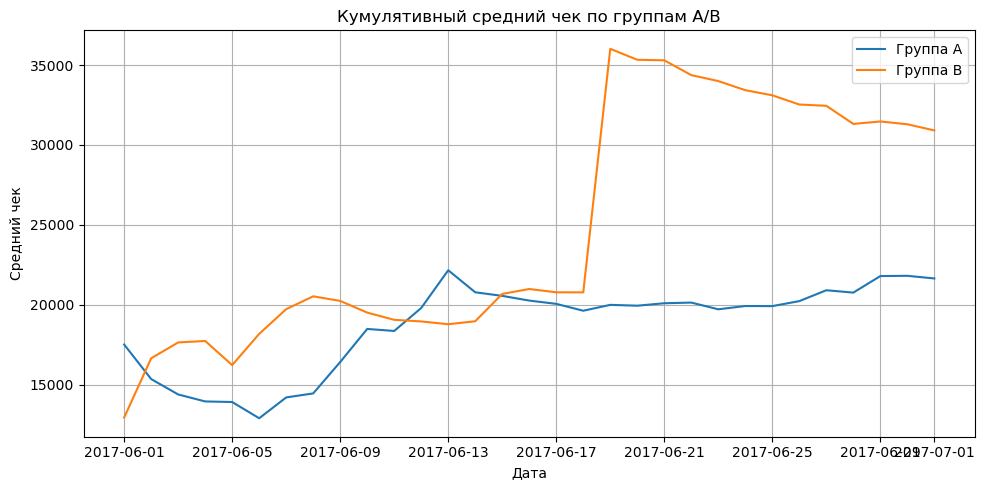

In [71]:
plt.figure(figsize=(10, 5))
for g in sorted(daily["group"].unique()):
    gd = daily[daily["group"] == g].dropna(subset=["cum_avg_check"])
    plt.plot(gd["date"], gd["cum_avg_check"], label=f"Группа {g}")

plt.title("Кумулятивный средний чек по группам A/B")
plt.xlabel("Дата")
plt.ylabel("Средний чек")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [72]:
summary = (
    daily.sort_values("date")
    .groupby("group", as_index=False)
    .tail(1)[["group", "cum_revenue", "cum_orders", "cum_avg_check"]]
    .reset_index(drop=True)
)
summary

,group,cum_revenue,cum_orders,cum_avg_check
0,A,12056583.8,557,21645.572352
1,B,19782257.0,640,30909.776562


Разрыв в кумулятивном среднем чеке формируется в основном из-за скачка в районе 19.06.2017, скорее всего из-за нескольких крупных покупок.

In [73]:
base_stats = (
    transactions.groupby("group")["revenue"]
    .agg(count="count", median="median", mean="mean", min="min", max="max")
    .round(2)
)
base_stats

,count,median,mean,min,max
group,,,,,
A,557,7302.4,21645.57,77.2,335266.0
B,640,7207.8,30909.78,77.2,6183359.6


Медианы чеков почти равные, а вот максимальные значения отличаются на порядок. Значит разница в среднем формируется из-за крупных выбросов в группе B

3. График относительного изменения кумулятивного среднего чека группы B к группе A. Опишите выводы

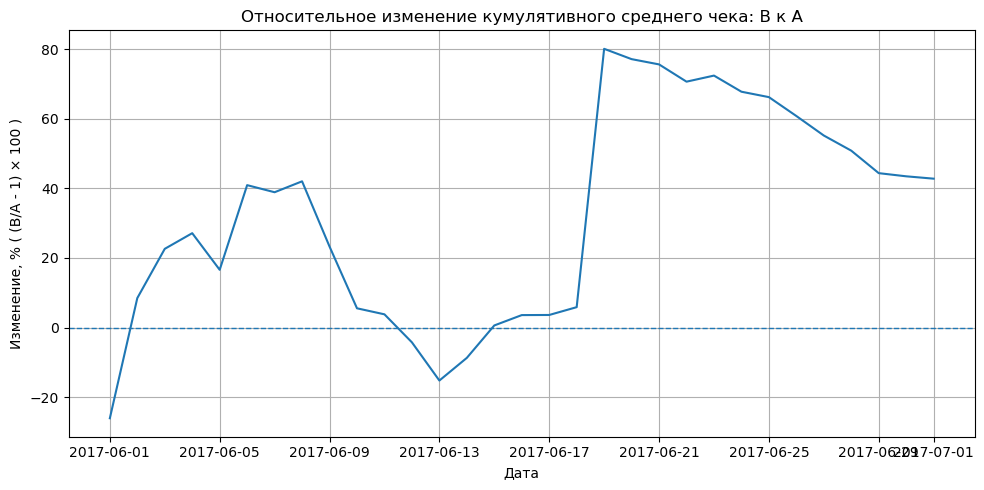

Финал: 42.80% на 2017-07-01
Максимум: 80.14% на 2017-06-19
Минимум: -26.08% на 2017-06-01


In [74]:
pivot_avg = daily.pivot(index="date", columns="group", values="cum_avg_check")


rel = pivot_avg["B"] / pivot_avg["A"] - 1
rel_pct = rel * 100


plt.figure(figsize=(10, 5))
plt.plot(rel_pct.index, rel_pct.values)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Относительное изменение кумулятивного среднего чека: B к A")
plt.xlabel("Дата")
plt.ylabel("Изменение, % ( (B/A - 1) × 100 )")
plt.tight_layout()
plt.grid()
plt.show()


final_val = rel_pct.iloc[-1]
peak_date, peak_val = rel_pct.idxmax(), rel_pct.max()
low_date, low_val = rel_pct.idxmin(), rel_pct.min()
print(
    f'Финал: {final_val:.2f}% на {final_val.index[-1] if hasattr(final_val,"index") else rel_pct.index[-1].date()}'
)
print(f"Максимум: {peak_val:.2f}% на {peak_date.date()}")
print(f"Минимум: {low_val:.2f}% на {low_date.date()}")

4. График кумулятивного среднего количества заказов по группам. 

In [75]:
users_cum = (
    users.assign(date=pd.to_datetime(users["date"]))
    .sort_values(["group", "date"])
    .assign(cum_users=lambda d: d.groupby("group")["count_users"].cumsum())[
        ["date", "group", "cum_users"]
    ]
)

orders_users = (
    daily[["date", "group", "cum_orders"]]
    .merge(users_cum, on=["date", "group"], how="inner")
    .sort_values(["group", "date"])
)

orders_users["cum_avg_orders"] = orders_users["cum_orders"] / orders_users["cum_users"]

In [76]:
users_cum.head()

,date,group,cum_users
0,2017-06-01,A,1016.0
1,2017-06-02,A,1884.0
2,2017-06-03,A,2588.0
3,2017-06-04,A,3601.0
4,2017-06-05,A,4673.0


In [77]:
orders_users.head()

,date,group,cum_orders,cum_users,cum_avg_orders
0,2017-06-01,A,24,1016.0,0.023622
1,2017-06-02,A,44,1884.0,0.023355
2,2017-06-03,A,68,2588.0,0.026275
3,2017-06-04,A,84,3601.0,0.023327
4,2017-06-05,A,109,4673.0,0.023325


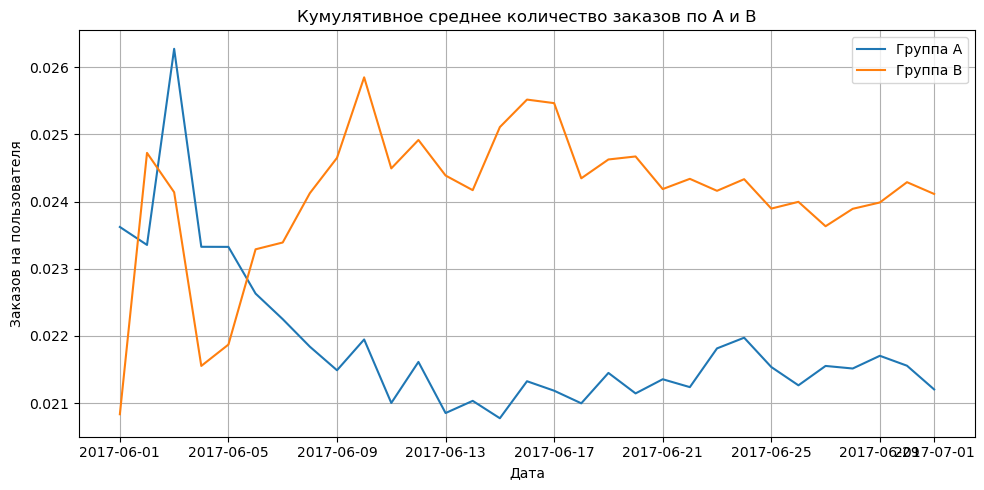

In [78]:
plt.figure(figsize=(10, 5))
for g in sorted(orders_users["group"].unique()):
    gd = orders_users[orders_users["group"] == g]
    plt.plot(gd["date"], gd["cum_avg_orders"], label=f"Группа {g}")
plt.title("Кумулятивное среднее количество заказов по A и B")
plt.xlabel("Дата")
plt.ylabel("Заказов на пользователя")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

5. График относительного изменения кумулятивного среднего количества заказов группы B к группе A

In [79]:
pivot_avg = orders_users.pivot(index="date", columns="group", values="cum_avg_orders")

rel_pct = (pivot_avg["B"] / pivot_avg["A"] - 1.0) * 100

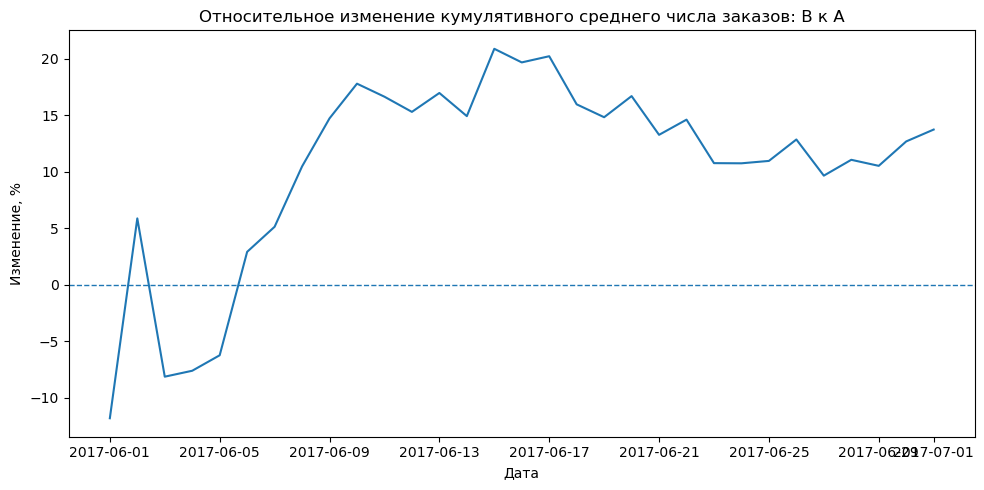

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(rel_pct.index, rel_pct.values)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Относительное изменение кумулятивного среднего числа заказов: B к A")
plt.xlabel("Дата")
plt.ylabel("Изменение, %")
plt.tight_layout()
plt.show()

6. Распределение количества заказов по пользователям.  Опишите выводы

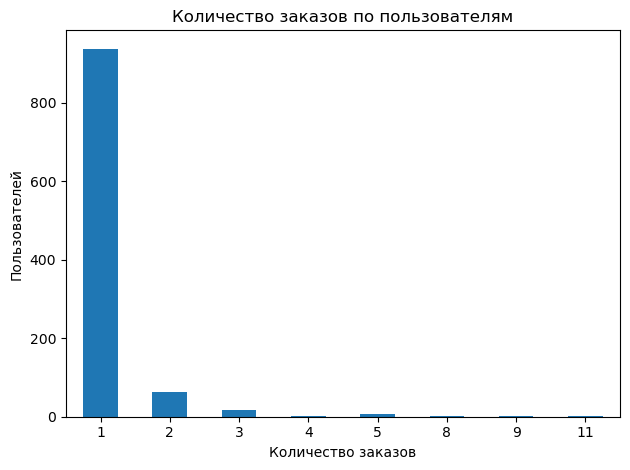

In [81]:
orders_by_users = transactions.copy()
avg_orders = (
    transactions.groupby(["user_id"])["transaction_id"]
    .count()
    .sort_values(ascending=False)
)
avg_orders.value_counts().sort_index().plot(kind="bar")

plt.xlabel("Количество заказов")
plt.ylabel("Пользователей")
plt.title("Количество заказов по пользователям")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [82]:
orders_per_user = transactions.groupby("user_id").size().rename("orders")

q95_all = orders_per_user.quantile(0.95)
q99_all = orders_per_user.quantile(0.99)

threshold = int(np.ceil(q99_all))
anomalous_users = orders_per_user[orders_per_user >= threshold]

print("Всего покупателей:", orders_per_user.shape[0])
print("95-й перцентиль:", q95_all)
print("99-й перцентиль:", q99_all)
print("Порог аномалии (ceil 99-го):", threshold)
print("Сколько попало под аномалию:", anomalous_users.shape[0])

Всего покупателей: 1031
95-й перцентиль: 2.0
99-й перцентиль: 4.0
Порог аномалии (ceil 99-го): 4
Сколько попало под аномалию: 13


8. Постройте распределение стоимостей заказов. Сделайте выводы и предположения.

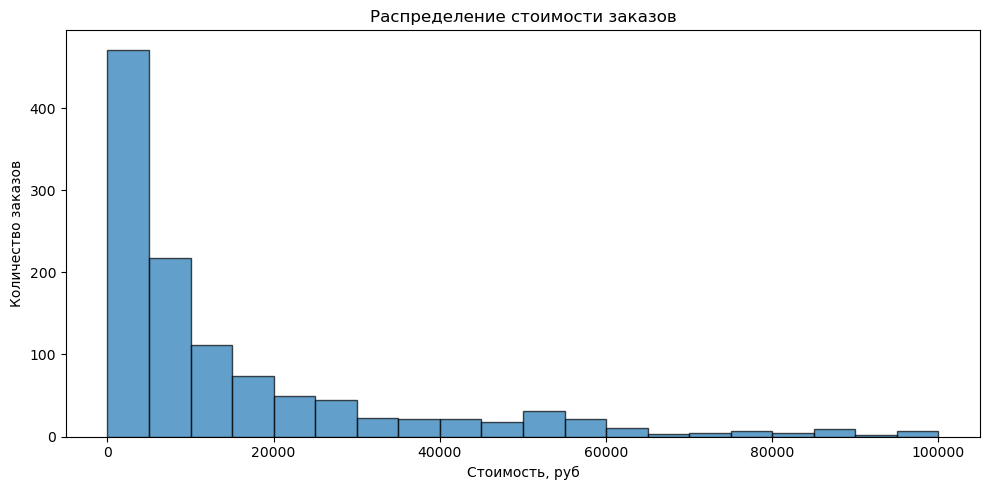

In [83]:
plt.figure(figsize=(10, 5))

bins = np.arange(0, 100000 + 5000, 5000)

plt.hist(transactions["revenue"], bins=bins, edgecolor="black", alpha=0.7)

plt.xlabel("Стоимость, руб")
plt.ylabel("Количество заказов")
plt.title("Распределение стоимости заказов")
plt.tight_layout()
plt.show()

In [84]:
summary = (
    transactions.groupby("group")["revenue"]
    .agg(
        count="count",
        median="median",
        mean="mean",
        q90=lambda s: s.quantile(0.9),
        q95=lambda s: s.quantile(0.95),
        q99=lambda s: s.quantile(0.99),
        max="max",
    )
    .round(2)
)
summary

,count,median,mean,q90,q95,q99,max
group,,,,,,,
A,557,7302.4,21645.57,53433.40,82923.04,214209.60,335266.0
B,640,7207.8,30909.78,55030.69,90088.88,187128.16,6183359.6


9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [ ]:
q95 = np.percentile(transactions["revenue"], 95)
q99 = np.percentile(transactions["revenue"], 99)
max_val = transactions["revenue"].max()

print("95-й перцентиль:", q95)
print("99-й перцентиль:", q99)
print("Максимальная стоимость заказа:", max_val)

threshold = q99
print("Граница для аномалий:", threshold)
print("Количество аномальных заказов:", (transactions["revenue"] >= threshold).sum())

95-й перцентиль: 87354.80000000002
99-й перцентиль: 197076.15199999994
Максимальная стоимость заказа: 6183359.6
Граница для аномалий: 197076.15199999994
Количество аномальных заказов: 12


10. Посчитайте статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. Сделайте выводы и предположения.

In [ ]:
orders_by_user = (
    transactions.groupby(["group", "user_id"]).size().reset_index(name="orders")
)


orders_A = orders_by_user.loc[orders_by_user["group"] == "A", "orders"]
orders_B = orders_by_user.loc[orders_by_user["group"] == "B", "orders"]


u_stat, p_value = st.mannwhitneyu(orders_A, orders_B, alternative="two-sided")

print("Среднее число заказов на пользователя, A:", orders_A.mean())
print("Среднее число заказов на пользователя, B:", orders_B.mean())
print("p-value:", p_value)

Среднее число заказов на пользователя, A: 1.1073558648111332
Среднее число заказов на пользователя, B: 1.0921501706484642
p-value: 0.8900592924670534


In [ ]:
orders_by_user.head()

,group,user_id,orders
0,A,383057,1
1,A,9719781,1
2,A,16816584,1
3,A,17381043,1
4,A,25682967,1


11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

In [ ]:
rev_A = transactions.loc[transactions["group"] == "A", "revenue"]
rev_B = transactions.loc[transactions["group"] == "B", "revenue"]

print("Средний чек A:", rev_A.mean())
print("Средний чек B:", rev_B.mean())
print("Медиана чека A:", rev_A.median())
print("Медиана чека B:", rev_B.median())

u_stat, p_value = st.mannwhitneyu(rev_A, rev_B, alternative="two-sided")
print("p-value:", p_value)

Средний чек A: 21645.5723518851
Средний чек B: 30909.7765625
Медиана чека A: 7302.4
Медиана чека B: 7207.8
p-value: 0.7292909855432458


12. Посчитайте статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным. Сделайте выводы и предположения.

In [91]:
orders_by_user = (
    transactions.groupby(["group", "user_id"]).size().reset_index(name="orders")
)


orders_clean = orders_by_user[orders_by_user["orders"] < 4]

orders_A = orders_clean.loc[orders_clean["group"] == "A", "orders"]
orders_B = orders_clean.loc[orders_clean["group"] == "B", "orders"]


u_stat, p_value = st.mannwhitneyu(orders_A, orders_B, alternative="two-sided")

print("Среднее число заказов на пользователя (A):", orders_A.mean())
print("Среднее число заказов на пользователя (B):", orders_B.mean())
print("p-value:", p_value)

Среднее число заказов на пользователя (A): 1.062374245472837
Среднее число заказов на пользователя (B): 1.056896551724138
p-value: 0.9833240158661715


In [ ]:
orders_clean95 = orders_by_user[orders_by_user["orders"] < 3]


orders_A = orders_clean95.loc[orders_clean95["group"] == "A", "orders"]
orders_B = orders_clean95.loc[orders_clean95["group"] == "B", "orders"]

u_stat, p_value = st.mannwhitneyu(orders_A, orders_B, alternative="two-sided")

print("Среднее число заказов на пользователя (A):", orders_A.mean())
print("Среднее число заказов на пользователя (B):", orders_B.mean())
print("p-value:", p_value)

Среднее число заказов на пользователя (A): 1.0346938775510204
Среднее число заказов на пользователя (B): 1.04
p-value: 0.6502487066479345


13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [93]:
threshold = np.percentile(transactions["revenue"], 99)

transactions_clean = transactions[transactions["revenue"] < threshold]


rev_A = transactions_clean.loc[transactions_clean["group"] == "A", "revenue"]
rev_B = transactions_clean.loc[transactions_clean["group"] == "B", "revenue"]

print("Средний чек A:", rev_A.mean())
print("Средний чек B:", rev_B.mean())
print("Медиана чека A:", rev_A.median())
print("Медиана чека B:", rev_B.median())

u_stat, p_value = st.mannwhitneyu(rev_A, rev_B, alternative="two-sided")
print("p-value:", p_value)

Средний чек A: 18585.995454545453
Средний чек B: 18944.24661417323
Медиана чека A: 7221.3
Медиана чека B: 7180.8
p-value: 0.6208626966847455


14. Примите решение по результатам теста и объясните его. Варианты решений:   
*  Остановить тест, зафиксировать победу одной из групп.  
*  Остановить тест, зафиксировать отсутствие различий между группами. 

Остановить тест, зафиксировать отсутствие различий между группами. 